# Learning Deep Generative Models: A Self-Study Implementation

## Why This Notebook?
This notebook was created as a hands-on learning exercise to understand how DCGANs and VAEs work by implementing them from scratch. Rather than using existing implementations, I chose to build everything myself to gain deeper insights into these architectures.

## What It Does
- Implements both DCGAN and VAE architectures using PyTorch
- Trains both models on the CIFAR-10 dataset
- Includes a custom evaluation metric (MiFID)
- Visualizes training progress and generated images

## What I Learned
Through this implementation, I gained practical understanding of:
- How both architectures work and their key differences
- Training dynamics and stability challenges
- The importance of proper evaluation metrics
- Common pitfalls and implementation challenges

While the implementation has room for improvement (like longer training periods and architectural optimizations), it served its primary purpose as a learning tool for understanding generative models.

# Evaluation of Generative Models

Here two generative models were trained on CIFAR10 dataset and the resulting images were evaluated using the Memorisation informed frechet inception distance (MiFID) and the performace of these two models were compared with each other. The two generative models used were DCGAN (Deep Convolutional Generative Adversarial Network) and VAE (Variational Autoencoder).


Created a DCGAN and trained the DCGAN on CIFAR10 dataset and tuned the hyperparameters (Learning rate, Epochs, Batch size) and calculated the MiFID for different hyperparamets to minimize the MiFID.<br>

Created a VAE. Trained the VAE on the same dataset as DCGAN and then calculated the MiFID.<br>

Main findings were that, MiFID plataued after certain epochs, increasing the learning rate beyond a threshold resulted in unexpected errors in during the training of the GAN.<br>

Even after training, images generated by the VAE had high MiFID values. Changing Hyperparameter values did not have significant impact on MiFID values.

    

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import time
import torch
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics.pairwise import cosine_distances as cd
from torchvision.models.inception import inception_v3, Inception_V3_Weights
from torch.autograd import Variable
from tqdm import tqdm
from tqdm import trange


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


ModuleNotFoundError: No module named 'torch'

In [2]:
# torch.cuda.empty_cache()

# Method



CIFAR10 dataset has been used to train the GAN and VAE . Even though the images were not resized , they were normalized as a preprocessing step(0.5 - Mean, 0.5 - Standard Deviation is used on all three channels as a preprocessings step).<BR>
    
The purpose of this normalization is to help the network converge faster during training by reducing the range of input pixel values and making them more consistent across different images. This is important because neural networks often learn better when the input data is normalized and centered around zero.<br>
    
The models used were DCGAN and VAE.These model were selected because they both are generative models and it will be possible to compare their performance against each other.
    
### DCGAN

  
**Generator** - It has 3 transpose-convolutional layers followed by batch normalization layers and has Relu as an activation function. However, in the last transpose-convolutional layer the activation function is Tanh().<br>
    
 Transposed convolution layer can be used to upsample the input tensor by a factor of 2 in the spatial dimensions (since the kernel size is 4 and the stride is 1). It is commonly used to transform a low-dimensional noise vector into a higher-dimensional image.<br> 
    
Batch normalization is a technique that normalizes the activations of a layer across a batch of samples, and is often used to improve the training stability and performance of deep neural networks. nn.BatchNorm2d applies batch normalization independently to each channel of the input tensor.<br>

During training, nn.BatchNorm2d computes a running mean and standard deviation of the input activations, and uses these statistics to normalize the activations of each channel.Overall, nn.BatchNorm2d can help improve the performance of deep CNNs by reducing the internal covariate shift, improving generalization, and accelerating convergence during training.<br>

**Discriminator** - It has 3 convolutional layers followed by a batch normalization layer has leaky Relu as an activation fuction. However, in the last layer it has sigmoid as an activation fuction.

### VAE
 
**Encoder** - Encoder has convolutional layers to capture the features of the training data. 
**Decoder** - Decoder has Transposed convolution layers that upsamples the latent space.
    
There are two additional layers here as well mean layer and variance layer to learn the distribution of the input data.
VAE has two losses as well. It has reconstruction loss and KL divergence loss. One is to check how different is the generated image from the input image and the other is to check how the input distribution differs from the generated distribution.
    
Tried changing the different hyperparameters to lower the MiFID value.
    
 

In [16]:

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

cf_cuda = False

fid_epsilon = 10e-15
# fid_epsilon = 1e-6 #Before value 
cosine_distance_eps = 0.1

In [45]:
device = torch.device("cpu")

In [46]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dset.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
# testset = dset.CIFAR10(root='./data/test', train=False,
#                                             download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=workers,drop_last=True)
# dataloader_test = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                               shuffle=True, num_workers=workers,drop_last=True)


# Decide which device we want to run on
device = torch.device("cpu")

# # Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Files already downloaded and verified


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        # Input: N x nz x 1 x 1
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False), # N x ngf*8 x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), # N x ngf*4 x 8 x 8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False), # N x ngf*2 x 16 x 16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False), # N x nc x 32 x 32
            nn.Tanh() # [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [10]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: N x nc x 32 x32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), #16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), #8x8
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), #4x4
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False), # 1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [12]:
# Initialize BCELoss function
# criterion = nn.BCELoss()
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training and Validating 

The DCGAN was trained on 400 epochs at first at the learning rate of 0.0002 and then used MiFID to validate the results. 

MiFID validates the generated images quality by performing the calculations on the feature vector on the last layer of the Inception model.


In [18]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
real_array = []
fake_array = []
real_array_batch = []
fake_array_batch = []
iters = 0
k= 4
data_l_len = len(dataloader)
print("Starting Training Loop...")
# For each epoch

for epoch in range(0,num_epochs):
    # For each batch in the dataloader
    since = time.time()
#     for i, data in enumerate(dataloader, 0):
    for i, data in tqdm(enumerate(dataloader, 0),total=int(len(trainset) / dataloader.batch_size)):    
#         if iters == batch_size*3:        
#             continue
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
#         real_cpu=0.9*real_cpu+0.1*torch.randn((real_cpu.size()), device=device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
#         with autocast():
#             errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
#         fake=0.9*fake+0.1*torch.randn((fake.size()), device=device)
#         real_array.append(real_cpu.cpu())
#         fake_array.append(fake.cpu())
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
#         with autocast():
#             errD_fake = criterion(output, label)
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
#         fretchet_dist = calculate_fretchet(real_cpu, fake, model)

        # Output training stats
        fretchet_dist = 0
#         if i % data_l_len == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item()))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
        time_elapsed = time.time() - since
#     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item()))    
    print(f'''Epoc {epoch} : Gen Loss : {errG.item()} \tDiscriminator loss: {errD.item()}''')
#     torch.cuda.empty_cache()

Starting Training Loop...


100%|██████████| 390/390 [00:20<00:00, 19.37it/s]

Epoc 0 : Gen Loss : 2.010145664215088 	Discriminator loss: 0.6753560304641724


In [21]:
# Save Generator
G_name = './Generator_ep'+str(epoch)+'_bt'+str(batch_size)+'LR2.pt'
D_name = './Discriminator_ep'+str(epoch)+'_bt'+str(batch_size)+'LR2.pt'
torch.save(netG,G_name)
torch.save(netD,D_name)

In [22]:
#Save loss
G_loss_name = './Generator_loss_ep'+str(epoch)+'_bt'+str(batch_size)+'LR2.pt'
D_loss_name = './Discriminator_loss_ep'+str(epoch)+'_bt'+str(batch_size)+'LR2.pt'
torch.save(G_losses,G_loss_name)
torch.save(D_losses,D_loss_name)

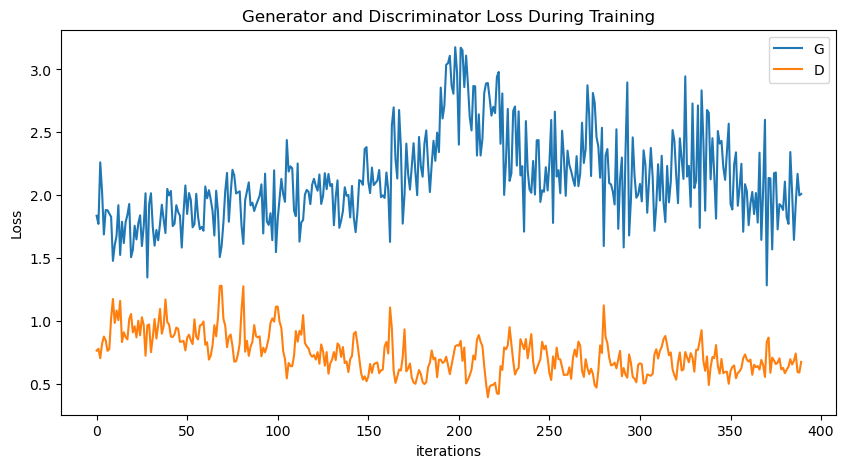

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




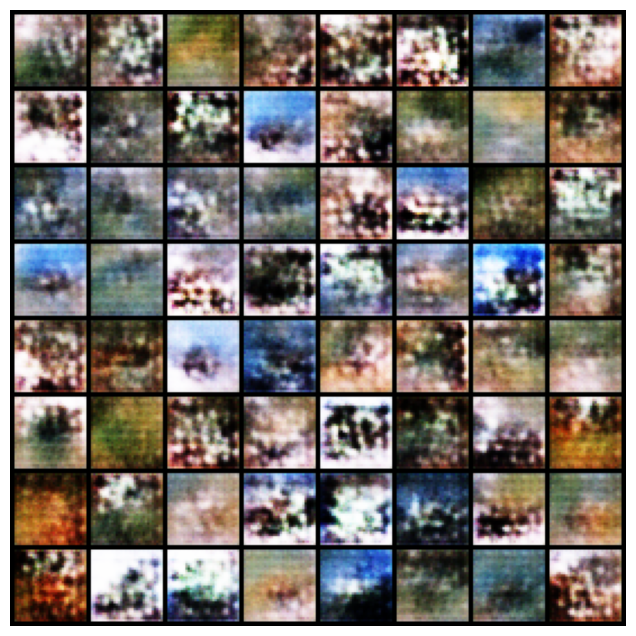

In [24]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




# MiFID


In [26]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
v3_model = InceptionV3([block_idx])
v3_model = v3_model.to(device)

C:\Users\44759\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\44759\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))

In [28]:
def calculate_activation_statistics(images,model,batch_size=batch_size, dims=2048,
                    cuda=True):
    model.eval()
    act=np.empty((len(images), dims))
    # model.to('cpu')
    if cuda:
        batch=images.cuda()
    else:
        batch=images.cpu()
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [29]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=fid_epsilon):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1) # Numpy array containing the activations of a layer of the inception net (like returned by the function 'get_predictions') for generated samples.
    mu2 = np.atleast_1d(mu2) # The sample mean over activations, precalculated on an representative data set.

    sigma1 = np.atleast_2d(sigma1) # The covariance matrix over activations for generated samples.
    sigma2 = np.atleast_2d(sigma2) # The covariance matrix over activations, precalculated on an representative data set.

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [30]:
def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

In [31]:
def cosine_distance_cal(features1, features2,model_type):
    features1 = features1.detach().cpu().numpy()
    features2 = features2.detach().cpu().numpy()
    features1_nozero = features1[np.sum(features1) != 0]
    features2_nozero = features2[np.sum(features2) != 0]
    if model_type=='GAN':
        norm_f1 = normalize_rows(features1_nozero)
        norm_f2 = normalize_rows(features2_nozero)
    else:
        norm_f1 = features1_nozero
        norm_f2 = features2_nozero
    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2))
    mean_min_d = np.mean(np.min(d, axis=1))
    return mean_min_d

In [32]:
def normalizeDATAInception(x):
    x = F.interpolate(x,
                      size=(299, 299),
                      mode='bilinear',
                      align_corners=False)
    x = 2 * x - 1
    return x

In [33]:
def calculate_fretchet(images_real,images_fake,model):
    real_img = normalizeDATAInception(images_real)
    fake_img = normalizeDATAInception(images_fake)
    
    mu_1,std_1=calculate_activation_statistics(images_real,model)
    mu_2,std_2=calculate_activation_statistics(images_fake,model)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [34]:
def return_f_d(real,fake,model,model_type):
    fretchet_dist = calculate_fretchet(real, fake, model)
    cos_distance = cosine_distance_cal(real, fake,model_type)
    cos_distance = distance_thresholding(cos_distance,cosine_distance_eps)
    mifid = fretchet_dist /(cos_distance + fid_epsilon)
    return fretchet_dist, mifid

In [25]:
# torch.cuda.empty_cache()

In [26]:
# #If loading pretrained Generator
# g_path = './models/Generator_ep100_bt128LR2.pt'
# netG = Generator(ngpu)
# netG = torch.load(g_path)

In [27]:
# print(netG)

In [35]:
#Create test Set
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = dset.CIFAR10(root='./data/test', train=False,
                                            download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True, num_workers=workers,drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/test\cifar-10-python.tar.gz to ./data/test


In [47]:
mifid_l = []
batch = 1
for i, data in enumerate(dataloader_test,0):    
    real_image = data[0].to(device)
    r_image_size = real_image.size(0)
    real_image.shape
    noise = torch.randn(r_image_size, nz, 1, 1, device=device)
    netG.to(device)
    fake_image = netG(noise)
    # fake_image.to('cpu')
    # real_image.to('cpu')
    real_image.shape
    

In [48]:
   real_image.shape

torch.Size([128, 3, 32, 32])

In [40]:
fid,mifid = return_f_d(real_image, fake_image, v3_model,'GAN')
    mifid_l.append(mifid)
    print(f"Test Batch: {batch} \tMiFID: {mifid:.4f}")
    batch=batch+1


IndentationError: unexpected indent (1217399245.py, line 2)

In [99]:
mfid_name = './evaluations/GAN_mfid_ep'+str(num_epochs)+'_bt'+str(batch_size)+'LR2.pt'
torch.save(mifid_l,mfid_name)

### Results and discussion

The MiFID seemed to plataue after 250 epochs the saved model during the training. The Mifid for various epochs can be checked using the model saved at constant intervals.

We have changed various hyperparmeters like learing rate, beta1 and the number of the feature maps , however this does seem to have an impact on the final MiFID value. However, When the learning rate was very high the GAN did not converge and losses had unexpected values.

However, We can try to get better results by modifying the model archicteure or training using more data to check whether this will have further impact on the MiFID value.

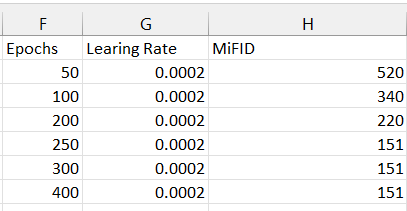
















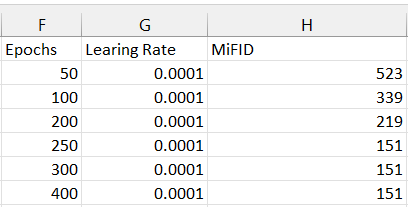

### Comparison with a second model 

DCGAN is compared with the performance of the VAE , However , DCGAN performed much better in generating images with low MiFID. However when the reconstruction loss was changed from MSE to BCE there were changes in the MiFID.

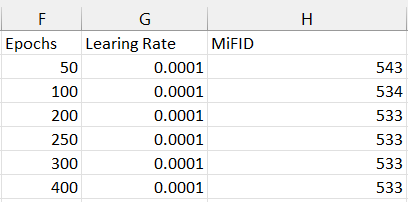

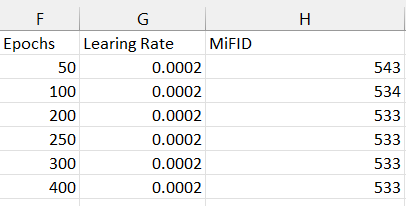

# VAE

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [102]:
num_epochs = num_epochs
batch_size = batch_size
learning_rate = lr


In [103]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_vae = dset.CIFAR10(root='./data/vae', train=True,
                                            download=True, transform=transform)
# testset = dset.CIFAR10(root='./data/test', train=False,
#                                             download=True, transform=transform)
dataloader_vae = torch.utils.data.DataLoader(trainset_vae, batch_size=batch_size,
                                              shuffle=True, num_workers=workers,drop_last=True)

Files already downloaded and verified


In [104]:
# Get some random batch of training images & labels-
images, labels = next(iter(dataloader_vae))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([128, 3, 32, 32]) & labels.shape: torch.Size([128])


In [105]:
# Unnormalize images-
images = images / 2 + 0.5
images = np.transpose(images.numpy(), (0, 2, 3, 1))

In [106]:
images.shape

(128, 32, 32, 3)

In [107]:
images[0].shape

(32, 32, 3)

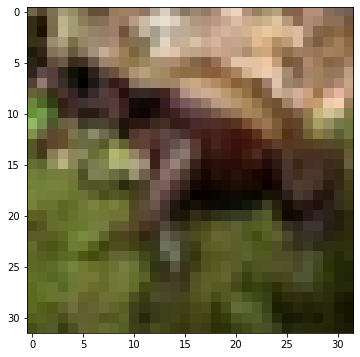

In [108]:
plt.figure(figsize = (7, 6))
plt.imshow(images[0])
plt.show()

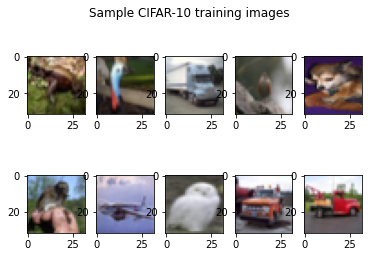

In [109]:
# Visualize 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i])
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

Define Variational Autoencoder architecture:

In [110]:
class cnn_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(cnn_block, self).__init__()

        # Define layers-
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = output_channels,
            kernel_size = 3, stride = 1,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = output_channels, out_channels = output_channels,
            kernel_size = 3, stride = 1,
            padding = 1, bias = True
        )
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2
        )
  

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        return self.pool(x)
    

In [111]:
class Conv6_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(Conv6_Encoder, self).__init__()
        self.latent_space = latent_space
        
        self.block1 = cnn_block(input_channels = 3, output_channels = 64)
        self.block2 = cnn_block(input_channels = 64, output_channels = 128)
        self.block3 = cnn_block(input_channels = 128, output_channels = 256)
        self.conv_layer = nn.Conv2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.dense_layer1 = nn.Linear(
            in_features = 1024, out_features = 500,
            bias = True
        )
        self.op_layer = nn.Linear(
            in_features = 500, out_features = self.latent_space,
            bias = True
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = F.leaky_relu(self.conv_layer(x))
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.op_layer(x))
        return x

In [112]:
class Conv6_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(Conv6_Decoder, self).__init__()
        self.latent_space = latent_space
    
        self.dense_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 500,
            bias = True
        )
        self.dense_layer2 = nn.Linear(
            in_features = 500, out_features = 1024,
            bias = True
        )
        self.conv_tran_layer = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv_tran_layer1 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv_tran_layer2 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.conv_tran_layer3 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 128,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv_tran_layer4 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.conv_tran_layer5 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 64,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv_tran_layer6 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.output_conv_layer = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 3,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        
    
    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        # x = x.view(-1, 256, 4, 4)
        x = x.view(-1, 256, 2, 2)
        x = F.leaky_relu(self.conv_tran_layer(x))
        x = F.leaky_relu(self.conv_tran_layer1(x))
        x = F.leaky_relu(self.conv_tran_layer2(x))
        x = F.leaky_relu(self.conv_tran_layer3(x))
        x = F.leaky_relu(self.conv_tran_layer4(x))
        x = F.leaky_relu(self.conv_tran_layer5(x))
        x = F.leaky_relu(self.conv_tran_layer6(x))
        x = self.output_conv_layer(x)
        return x

In [113]:
class VAE_Conv(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Conv, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = Conv6_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'hidden2mu' & 'hidden2log' to convert the bottleneck into the μ and σ vectors-
        self.hidden2mu = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        self.hidden2log_var = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        
        # Decoder-
        self.decoder = Conv6_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        # x = self.decoder(z)
        # recon_data = torch.sigmoid(x) # or, tanh
        
        return recon_data, mu, log_var

In [114]:
model = VAE_Conv(latent_space = 200).to(device)

In [115]:
print(model)

VAE_Conv(
  (encoder): Conv6_Encoder(
    (block1): cnn_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): cnn_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): cnn_block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_layer): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (dense_layer1): Linear(in_features=1

In [116]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.0002 will be used


In [117]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [118]:
# Reconstruction loss-
# criterion = nn.BCELoss(reduction = 'sum')

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch
# documentations, then this is specifically for the case of autoencoders only.

# Also, MSE loss could also be used-
criterion = nn.MSELoss(reduction = 'sum')

In [119]:
def total_loss(reconstruction_loss, mu, log_var, alpha = 1):
    '''
    Function to add reconstruction loss and KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    4. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss.
    '''
    
    # reconstruction_loss = F.binary_cross_entropy_with_logits(input, target)
    
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # final_loss = reconstruction_loss + KLD
    final_loss = (reconstruction_loss * alpha) + KLD
    
    return final_loss

In [120]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1
vae_losses = []
for epoch in range(1, num_epochs + 1):
    since = time.time()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader_vae),total = int(len(trainset_vae) / dataloader_vae.batch_size)):
        data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        recon_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(recon_loss, mu, logvar, alpha)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
      
    train_loss = running_loss / len(dataloader_vae.dataset)
    vae_losses.append(train_loss)
    time_elapsed = time.time() - since    
    print(f"Epoc: {epoch} Loss:{train_loss:.4f} Time:{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")    


100%|██████████| 390/390 [00:15<00:00, 25.37it/s]

Epoc: 1 Loss:813.6149 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.18it/s]

Epoc: 2 Loss:785.2395 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.14it/s]

Epoc: 3 Loss:785.2141 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.29it/s]

Epoc: 4 Loss:785.1165 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.20it/s]

Epoc: 5 Loss:785.1679 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.28it/s]

Epoc: 6 Loss:785.2451 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.14it/s]

Epoc: 7 Loss:785.1448 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.16it/s]

Epoc: 8 Loss:785.0809 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.38it/s]

Epoc: 9 Loss:785.0900 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.14it/s]

Epoc: 10 Loss:785.1143 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.44it/s]

Epoc: 11 Loss:785.2393 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.17it/s]

Epoc: 12 Loss:785.2402 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.22it/s]

Epoc: 13 Loss:785.1889 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.41it/s]

Epoc: 14 Loss:785.1064 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.20it/s]

Epoc: 15 Loss:785.0503 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.35it/s]

Epoc: 16 Loss:785.1401 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.23it/s]

Epoc: 17 Loss:785.1911 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.21it/s]

Epoc: 18 Loss:785.0300 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.33it/s]

Epoc: 19 Loss:785.1707 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.17it/s]

Epoc: 20 Loss:785.1482 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.35it/s]

Epoc: 21 Loss:785.1788 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.25it/s]

Epoc: 22 Loss:785.1544 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.16it/s]

Epoc: 23 Loss:785.0989 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.34it/s]

Epoc: 24 Loss:785.0063 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.15it/s]

Epoc: 25 Loss:785.1639 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.27it/s]

Epoc: 26 Loss:785.1779 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.10it/s]

Epoc: 27 Loss:784.9469 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.12it/s]

Epoc: 28 Loss:785.0999 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.30it/s]

Epoc: 29 Loss:785.1239 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.07it/s]

Epoc: 30 Loss:785.2308 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.21it/s]

Epoc: 31 Loss:785.1528 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.10it/s]

Epoc: 32 Loss:785.0280 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.14it/s]

Epoc: 33 Loss:785.2191 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.30it/s]

Epoc: 34 Loss:785.3030 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.21it/s]

Epoc: 35 Loss:785.2457 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.14it/s]

Epoc: 36 Loss:785.1751 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.24it/s]

Epoc: 37 Loss:785.2391 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.11it/s]

Epoc: 38 Loss:785.1105 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.40it/s]

Epoc: 39 Loss:785.1515 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.25it/s]

Epoc: 40 Loss:785.1182 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.19it/s]

Epoc: 41 Loss:785.0609 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.43it/s]

Epoc: 42 Loss:785.2189 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.27it/s]

Epoc: 43 Loss:785.0912 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.44it/s]

Epoc: 44 Loss:785.0366 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.24it/s]

Epoc: 45 Loss:785.2201 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.23it/s]

Epoc: 46 Loss:785.0828 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.48it/s]

Epoc: 47 Loss:785.1737 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.26it/s]

Epoc: 48 Loss:785.1439 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.35it/s]

Epoc: 49 Loss:785.1567 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.18it/s]

Epoc: 50 Loss:785.1869 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.18it/s]

Epoc: 51 Loss:785.1496 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.33it/s]

Epoc: 52 Loss:785.1040 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.11it/s]

Epoc: 53 Loss:785.1072 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.29it/s]

Epoc: 54 Loss:785.1484 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.26it/s]

Epoc: 55 Loss:785.1785 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.15it/s]

Epoc: 56 Loss:785.0731 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.38it/s]

Epoc: 57 Loss:785.1701 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.15it/s]

Epoc: 58 Loss:785.1931 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.17it/s]

Epoc: 59 Loss:785.1480 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.37it/s]

Epoc: 60 Loss:785.2506 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.25it/s]

Epoc: 61 Loss:785.1547 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.47it/s]

Epoc: 62 Loss:785.0373 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.20it/s]

Epoc: 63 Loss:785.1002 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.24it/s]

Epoc: 64 Loss:785.1174 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.39it/s]

Epoc: 65 Loss:785.2063 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.26it/s]

Epoc: 66 Loss:785.1933 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.43it/s]

Epoc: 67 Loss:785.1074 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.28it/s]

Epoc: 68 Loss:785.1868 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.18it/s]

Epoc: 69 Loss:785.1198 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.44it/s]

Epoc: 70 Loss:785.1918 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.29it/s]

Epoc: 71 Loss:785.1251 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.20it/s]

Epoc: 72 Loss:785.3021 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.19it/s]

Epoc: 73 Loss:785.1899 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.25it/s]

Epoc: 74 Loss:785.0800 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.43it/s]

Epoc: 75 Loss:785.1945 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.26it/s]

Epoc: 76 Loss:785.0319 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.21it/s]

Epoc: 77 Loss:785.1803 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.40it/s]

Epoc: 78 Loss:785.2434 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.19it/s]

Epoc: 79 Loss:785.1147 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.48it/s]

Epoc: 80 Loss:785.1369 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.33it/s]

Epoc: 81 Loss:785.1696 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.31it/s]

Epoc: 82 Loss:785.1611 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.50it/s]

Epoc: 83 Loss:785.1496 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.28it/s]

Epoc: 84 Loss:785.0725 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.20it/s]

Epoc: 85 Loss:785.2207 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.35it/s]

Epoc: 86 Loss:785.1934 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.22it/s]

Epoc: 87 Loss:785.1149 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.43it/s]

Epoc: 88 Loss:785.2481 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.21it/s]

Epoc: 89 Loss:785.1481 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.26it/s]

Epoc: 90 Loss:785.0467 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.48it/s]

Epoc: 91 Loss:785.0700 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.27it/s]

Epoc: 92 Loss:785.1535 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.57it/s]

Epoc: 93 Loss:785.0979 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.21it/s]

Epoc: 94 Loss:785.2732 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.17it/s]

Epoc: 95 Loss:785.1017 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.45it/s]

Epoc: 96 Loss:785.1818 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.21it/s]

Epoc: 97 Loss:785.2891 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.26it/s]

Epoc: 98 Loss:785.1392 Time:0m 16s



100%|██████████| 390/390 [00:15<00:00, 25.33it/s]

Epoc: 99 Loss:785.0526 Time:0m 15s



100%|██████████| 390/390 [00:15<00:00, 25.19it/s]

Epoc: 100 Loss:785.1311 Time:0m 16s


In [121]:
# Save Model
vae_name = './models/VAE_ep'+str(epoch)+'_bt'+str(batch_size)+'LR2.pt'
torch.save(model,vae_name)

In [122]:
# #to load model
# model = torch.load('./models/VAE_ep101_bt128LR2.pt')

In [123]:
#Save loss
VAE_loss_name = './losses/VAE_loss_ep'+str(epoch+1)+'_bt'+str(batch_size)+'LR2.pt'

torch.save(vae_losses,VAE_loss_name)

In [124]:
#Create test Set
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = dset.CIFAR10(root='./data/vae/test', train=False,
                                            download=True, transform=transform)
dataloader_test_vae = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True, num_workers=workers,drop_last=True)

Files already downloaded and verified


In [125]:
mifid_l_vae = []
batch = 1
for i, data in enumerate(dataloader_test_vae, 0):
    real_image = data[0].to(device)
    r_image_size = real_image.size(0)
    recon_images, mu, log_var = model(real_image)
    fid,mifid = return_f_d(real_image, recon_images, v3_model,'VAE')
    mifid_l_vae.append(mifid)
    print(f"Test Batch: {batch}\tMiFID: {mifid}")
    batch=batch+1



/home/ubuntu/.local/lib/python3.8/site-packages/scipy/linalg/_matfuncs_sqrtm.py:189: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


Test Batch: 1	MiFID: 509.941180517344
Test Batch: 2	MiFID: 516.2150144537692
Test Batch: 3	MiFID: 527.4464192435025
Test Batch: 4	MiFID: 521.4496269302142
Test Batch: 5	MiFID: 516.4331973876996
Test Batch: 6	MiFID: 527.6941674149899
Test Batch: 7	MiFID: 504.97646892123765
Test Batch: 8	MiFID: 528.0950149892019
Test Batch: 9	MiFID: 524.8425594382303
Test Batch: 10	MiFID: 524.3118474740216
Test Batch: 11	MiFID: 522.5788470000214
Test Batch: 12	MiFID: 541.055115779428
Test Batch: 13	MiFID: 525.8147497810746
Test Batch: 14	MiFID: 529.1052859304976
Test Batch: 15	MiFID: 521.6057185101799
Test Batch: 16	MiFID: 515.984170427205
Test Batch: 17	MiFID: 537.5572148929796
Test Batch: 18	MiFID: 524.7532211975123
Test Batch: 19	MiFID: 523.9640626279754
Test Batch: 20	MiFID: 513.2346661049734
Test Batch: 21	MiFID: 504.09551881293464
Test Batch: 22	MiFID: 516.0210029764334
Test Batch: 23	MiFID: 527.9159918352539
Test Batch: 24	MiFID: 520.1122718923698
Test Batch: 25	MiFID: 523.3452243341937
Test Batch

In [126]:
vae_mfid_name = './evaluations/VAE_mfid_ep'+str(num_epochs)+'_bt'+str(batch_size)+'LR2.pt'
torch.save(mifid_l_vae,vae_mfid_name)

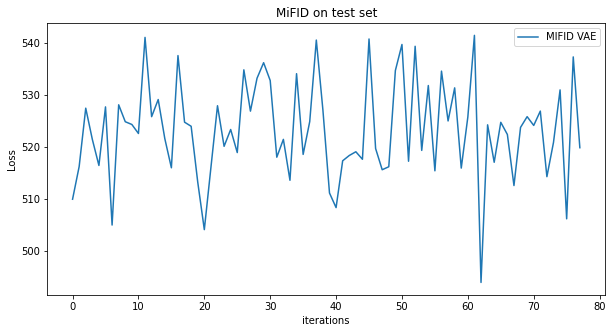

In [127]:
plt.figure(figsize=(10,5))
plt.title("MiFID on test set")
plt.plot(mifid_l_vae,label="MIFID VAE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Summary and Recommendation


Major observation was the number of epochs the training is done does not affect the MiFID after 250 epochs. However, whether this is true in case of other datasets is something to be investigated further. 

Increasing the learning rate beyond a certain threshold resulted in unexpected loss values.

## References


https://github.com/arjun-majumdar/Autoencoders_Experiments/blob/master/VAE_PyTorch_CIFAR10.ipynb<br>
https://colab.research.google.com/drive/1csLxcan3YYy1JkkkHTA-ozz92ol5oDb4?usp=sharing<br>
https://www.kaggle.com/c/generative-dog-images/overview/evaluation<br>
https://colab.research.google.com/drive/1mj5-TOSS-1k0PNbKPHkSN_FgYwspBGN9?usp=sharing<br>